In [ ]:
from cleaner.cleaner import Cleaner
from utils.utils import Utils
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor

In [2]:
df = Cleaner.clean_data()

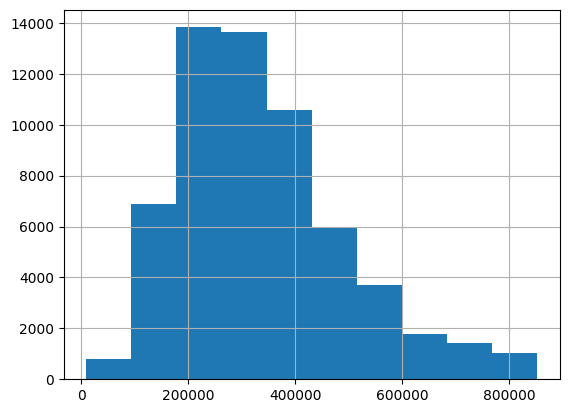

In [3]:
numerical_features = ["bedroomCount", "habitableSurface", "facedeCount", "streetFacadeWidth", "kitchenSurface", "landSurface", 
                      "terraceSurface", "gardenSurface", "toiletCount", "bathroomCount"]
categorical_features = [
    "type",
    "subtype",
    "province",
    "locality",
    "postCode",
    "hasBasement",
    "buildingCondition",
    "buildingConstructionYear",
    "hasTerrace",
    "floodZoneType",
    "heatingType",
    "kitchenType",
    "gardenOrientation",
    "hasSwimmingPool",
    
    "terraceOrientation",
    "epcScore"
]

cat_features_to_imput = ['buildingCondition', 'floodZoneType', 'heatingType', 'kitchenType', 'gardenOrientation', 'terraceOrientation', 'epcScore']

target_name = "price"

X = df[numerical_features + categorical_features]
y = df[target_name]

_ = y.hist()

In [4]:
categorical_preprocessors = [
    ("drop", "drop"),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    (
        "one_hot",
        OneHotEncoder(handle_unknown="ignore", max_categories=20, sparse_output=False),
    ),
    ("target", TargetEncoder(target_type="continuous")),
]

In [5]:
n_cv_folds = 5
max_iter = 20
results = []

for name, categorical_preprocessor in categorical_preprocessors:
    preprocessor = ColumnTransformer(
        [
            ("numerical", "passthrough", numerical_features),
            ("categorical", categorical_preprocessor, categorical_features),
        ]
    )
    pipe = make_pipeline(
        preprocessor, HistGradientBoostingRegressor(random_state = 0, max_iter = max_iter)
    )
    results = Utils.evaluate_model_and_store(X, y, name, pipe, res = results)

In [6]:
print(results)

[{'preprocessor': 'drop', 'mae_test_mean': np.float64(94374.70727187648), 'mae_test_std': np.float64(8670.190064903454), 'mae_train_mean': np.float64(89451.34252303041), 'mae_train_std': np.float64(1080.9157755081105)}, {'preprocessor': 'ordinal', 'mae_test_mean': np.float64(79254.08982071595), 'mae_test_std': np.float64(9325.739186113562), 'mae_train_mean': np.float64(68315.21648367579), 'mae_train_std': np.float64(1119.023951509332)}, {'preprocessor': 'one_hot', 'mae_test_mean': np.float64(83550.35698539307), 'mae_test_std': np.float64(10813.857716823), 'mae_train_mean': np.float64(71025.12280472815), 'mae_train_std': np.float64(851.7890045216329)}, {'preprocessor': 'target', 'mae_test_mean': np.float64(74620.51353724196), 'mae_test_std': np.float64(5151.85084283615), 'mae_train_mean': np.float64(63715.71903148511), 'mae_train_std': np.float64(720.993860992632)}]


In [7]:
n_unique_categories = df[categorical_features].nunique().sort_values(ascending=False)
n_unique_categories

high_cardinality_features = n_unique_categories[n_unique_categories > 255].index
low_cardinality_features = n_unique_categories[n_unique_categories <= 255].index
high_cardinality_features, low_cardinality_features

(Index(['locality', 'postCode'], dtype='object'),
 Index(['buildingConstructionYear', 'subtype', 'province', 'floodZoneType',
        'epcScore', 'gardenOrientation', 'terraceOrientation', 'kitchenType',
        'heatingType', 'buildingCondition', 'hasBasement', 'type', 'hasTerrace',
        'hasSwimmingPool'],
       dtype='object'))

In [8]:
mixed_encoded_preprocessor = ColumnTransformer(
    [
        ("numerical", "passthrough", numerical_features),
        (
            "high_cardinality",
            TargetEncoder(target_type="continuous"),
            high_cardinality_features
        ),
        (
            "low_cardinality",
            OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1),
            low_cardinality_features
        )
    ],
    verbose_feature_names_out = False
)

# The output of the of the preprocessor must be set to pandas so the
# gradient boosting model can detect the low cardinality features.
mixed_encoded_preprocessor.set_output(transform = "pandas")
mixed_pipe = make_pipeline(
    mixed_encoded_preprocessor,
    HistGradientBoostingRegressor(
        random_state = 0, max_iter = max_iter, categorical_features =low_cardinality_features
    )
)
mixed_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical', 'passthrough',
                                                  ['bedroomCount',
                                                   'habitableSurface',
                                                   'facedeCount',
                                                   'streetFacadeWidth',
                                                   'kitchenSurface',
                                                   'landSurface',
                                                   'terraceSurface',
                                                   'gardenSurface',
                                                   'toiletCount',
                                                   'bathroomCount']),
                                                 ('high_cardinality',
                                                  TargetEncoder(target_type='continuous'),
                                                  Index(['locality', 'postCode']...
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=Index(['buildingConstructionYear', 'subtype', 'province', 'floodZoneType',
       'epcScore', 'gardenOrientation', 'terraceOrientation', 'kitchenType',
       'heatingType', 'buildingCondition', 'hasBasement', 'type', 'hasTerrace',
       'hasSwimmingPool'],
      dtype='object'),
                                               max_iter=20, random_state=0))])

In [9]:
results = Utils.evaluate_model_and_store(X, y, "mixed_target", mixed_pipe, res = results)

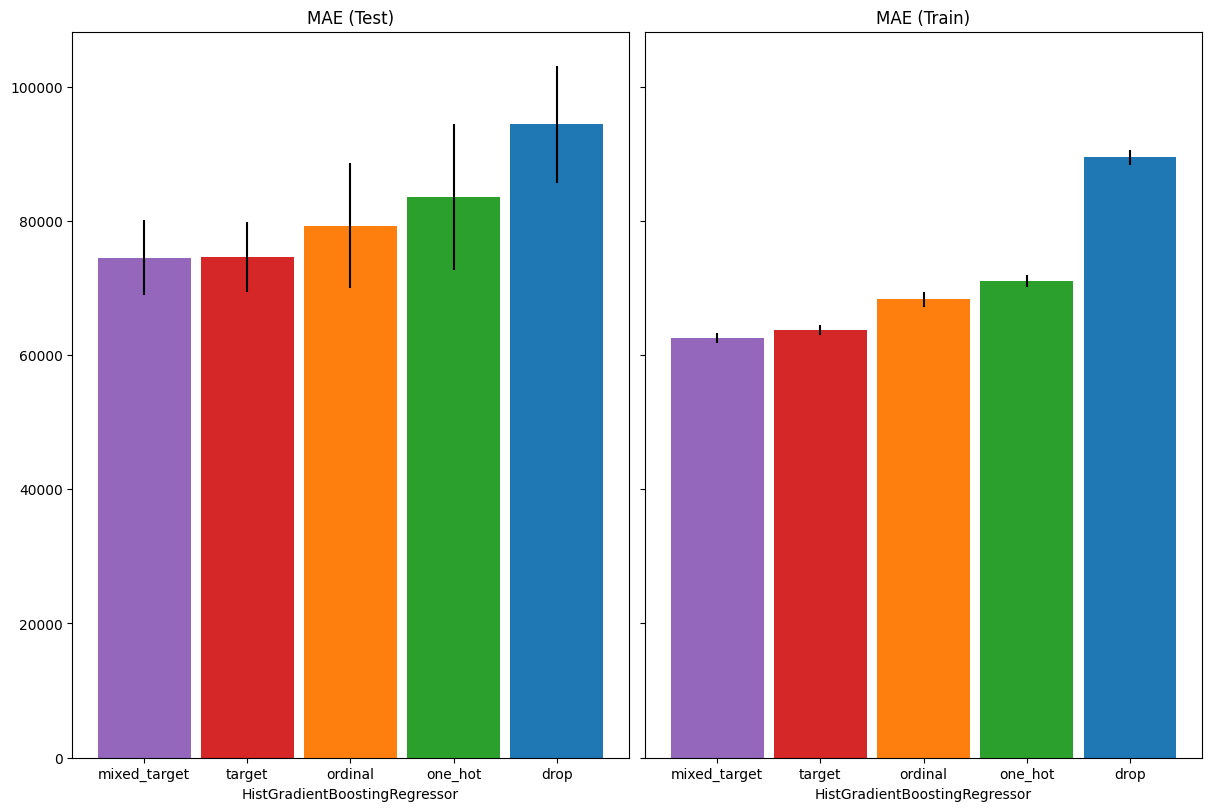

In [10]:
Utils.visualize_results(results, 'HistGradientBoostingRegressor')

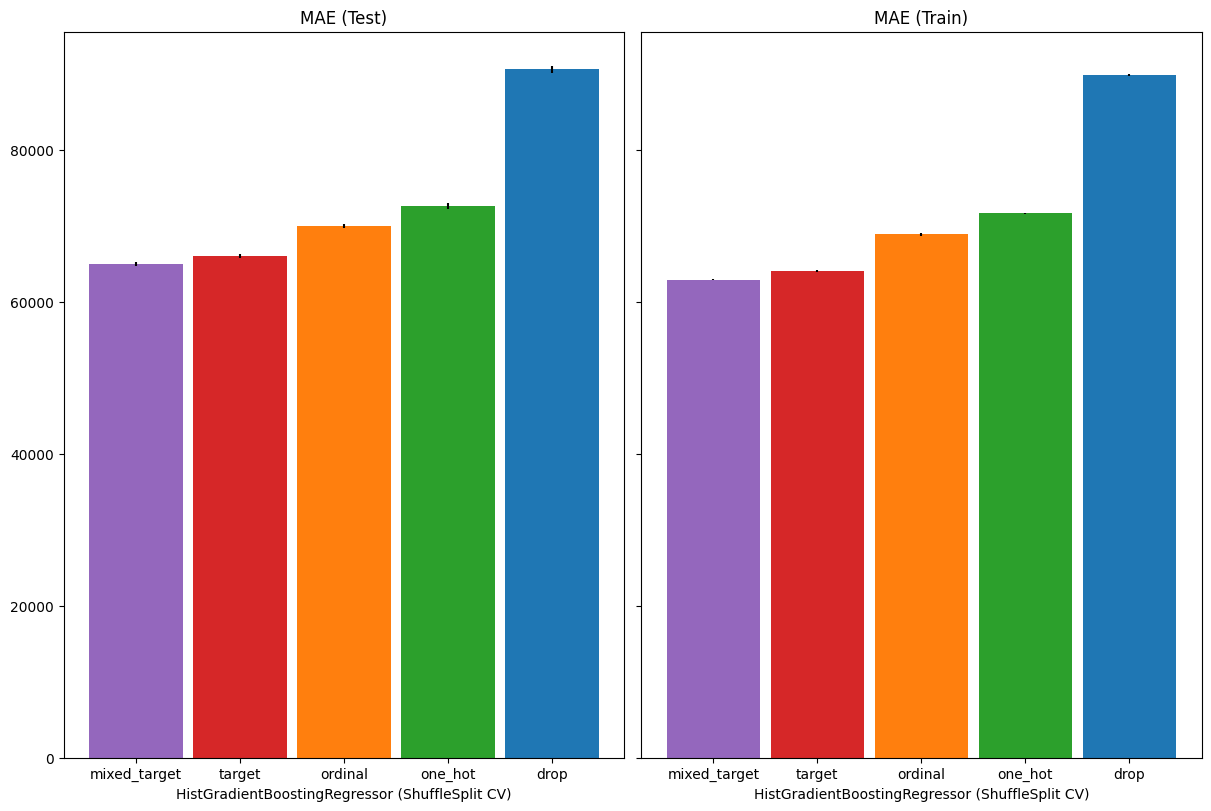

In [11]:
cv_shuffle_split = ShuffleSplit(n_splits = n_cv_folds, test_size = 0.25, random_state = 0)
results = []
for name, categorical_preprocessor in categorical_preprocessors:
    preprocessor = ColumnTransformer(
        [
            ("numerical", "passthrough", numerical_features),
            ("categorical", categorical_preprocessor, categorical_features),
        ]
    )
    pipe = make_pipeline(
        preprocessor, HistGradientBoostingRegressor(random_state = 0, max_iter = max_iter)
    )
    results = Utils.evaluate_model_and_store(X, y, name, pipe, cv_shuffle_split, res = results)

results = Utils.evaluate_model_and_store(X, y, "mixed_target", mixed_pipe, cv_shuffle_split, res = results)

Utils.visualize_results(results, 'HistGradientBoostingRegressor (ShuffleSplit CV)')

[{'preprocessor': 'RF_drop', 'mae_test_mean': np.float64(87323.17265766041), 'mae_test_std': np.float64(516.4625920404883), 'mae_train_mean': np.float64(39840.071651177575), 'mae_train_std': np.float64(133.41729693875823)}, {'preprocessor': 'RF_ordinal', 'mae_test_mean': np.float64(53134.955391046824), 'mae_test_std': np.float64(155.7334080046651), 'mae_train_mean': np.float64(20034.714619230937), 'mae_train_std': np.float64(59.61032630005359)}, {'preprocessor': 'RF_one_hot', 'mae_test_mean': np.float64(56964.48970906138), 'mae_test_std': np.float64(124.61610522313919), 'mae_train_mean': np.float64(21571.923522578636), 'mae_train_std': np.float64(40.32223532765919)}, {'preprocessor': 'RF_target', 'mae_test_mean': np.float64(55426.67921809219), 'mae_test_std': np.float64(270.8719265333326), 'mae_train_mean': np.float64(36893.76147762374), 'mae_train_std': np.float64(151.09445368022924)}, {'preprocessor': 'RF_mixed', 'mae_test_mean': np.float64(54805.67911130495), 'mae_test_std': np.floa

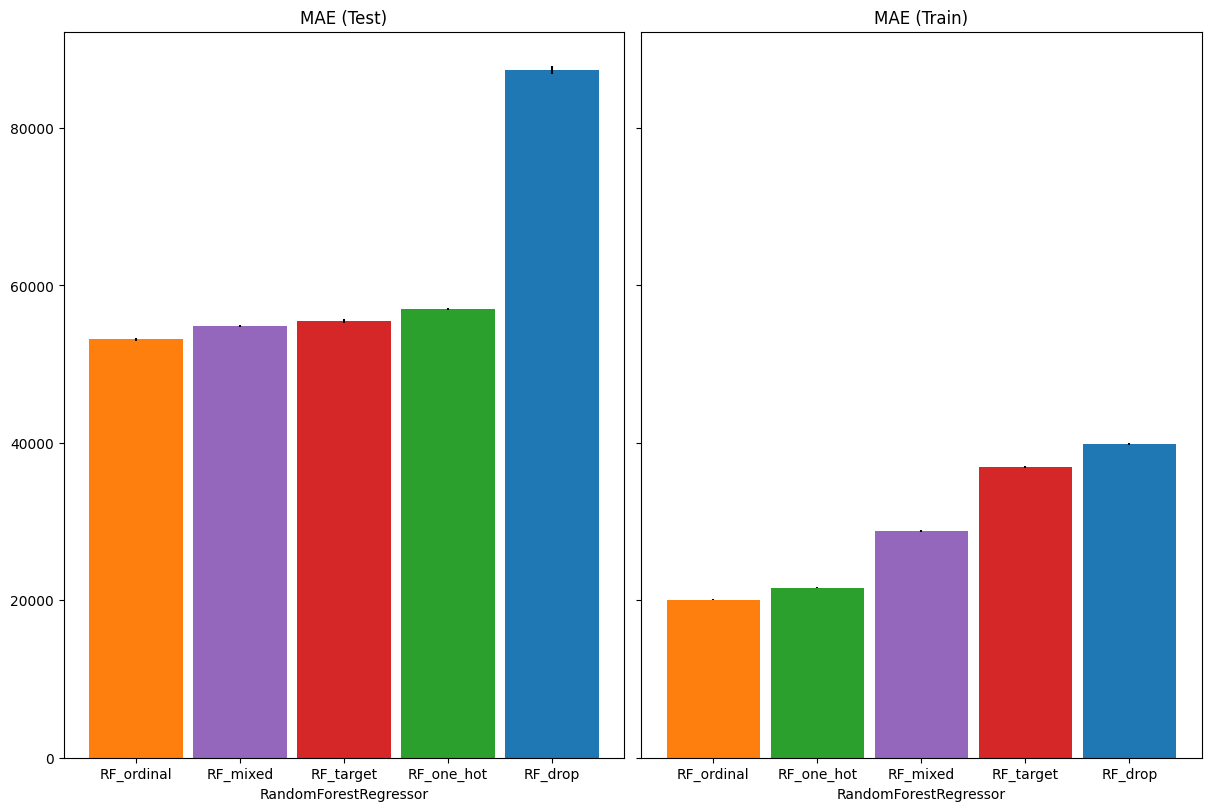

In [ ]:
# with RandomForestRegressor
results = []
imputer = SimpleImputer(strategy = 'most_frequent')

for name, categorical_preprocessor in categorical_preprocessors:
    preprocessor = ColumnTransformer(
        [
            ("numerical", "passthrough", numerical_features),
            ("categorical", categorical_preprocessor, categorical_features),
        ]
    )
    pipe = make_pipeline(
        preprocessor, imputer, RandomForestRegressor(random_state = 0, n_estimators = 40)
    )
    results = Utils.evaluate_model_and_store(X, y, f'RF_{name}', pipe, cv_shuffle_split, res = results)

RF_pipe = make_pipeline(
    mixed_encoded_preprocessor, imputer, RandomForestRegressor(random_state = 0, n_estimators = 40)
)

results = Utils.evaluate_model_and_store(X, y, 'RF_mixed', RF_pipe, cv_shuffle_split, res = results)
Utils.visualize_results(results, 'RandomForestRegressor')
print(results)

[{'preprocessor': 'RF_10_estimators', 'mae_test_mean': np.float64(56339.37721217454), 'mae_test_std': np.float64(186.40486388601371), 'mae_train_mean': np.float64(22639.756417188444), 'mae_train_std': np.float64(68.93386006374557)}, {'preprocessor': 'RF_20_estimators', 'mae_test_mean': np.float64(54551.74647487652), 'mae_test_std': np.float64(189.99297242944493), 'mae_train_mean': np.float64(21169.24023372001), 'mae_train_std': np.float64(67.81124906565006)}, {'preprocessor': 'RF_40_estimators', 'mae_test_mean': np.float64(53659.40339537134), 'mae_test_std': np.float64(231.46840065668528), 'mae_train_mean': np.float64(20288.42509415179), 'mae_train_std': np.float64(56.495563154585156)}, {'preprocessor': 'RF_80_estimators', 'mae_test_mean': np.float64(53246.25008945294), 'mae_test_std': np.float64(166.8443321916972), 'mae_train_mean': np.float64(19842.154526449944), 'mae_train_std': np.float64(38.53965308500937)}, {'preprocessor': 'RF_100_estimators', 'mae_test_mean': np.float64(53180.8

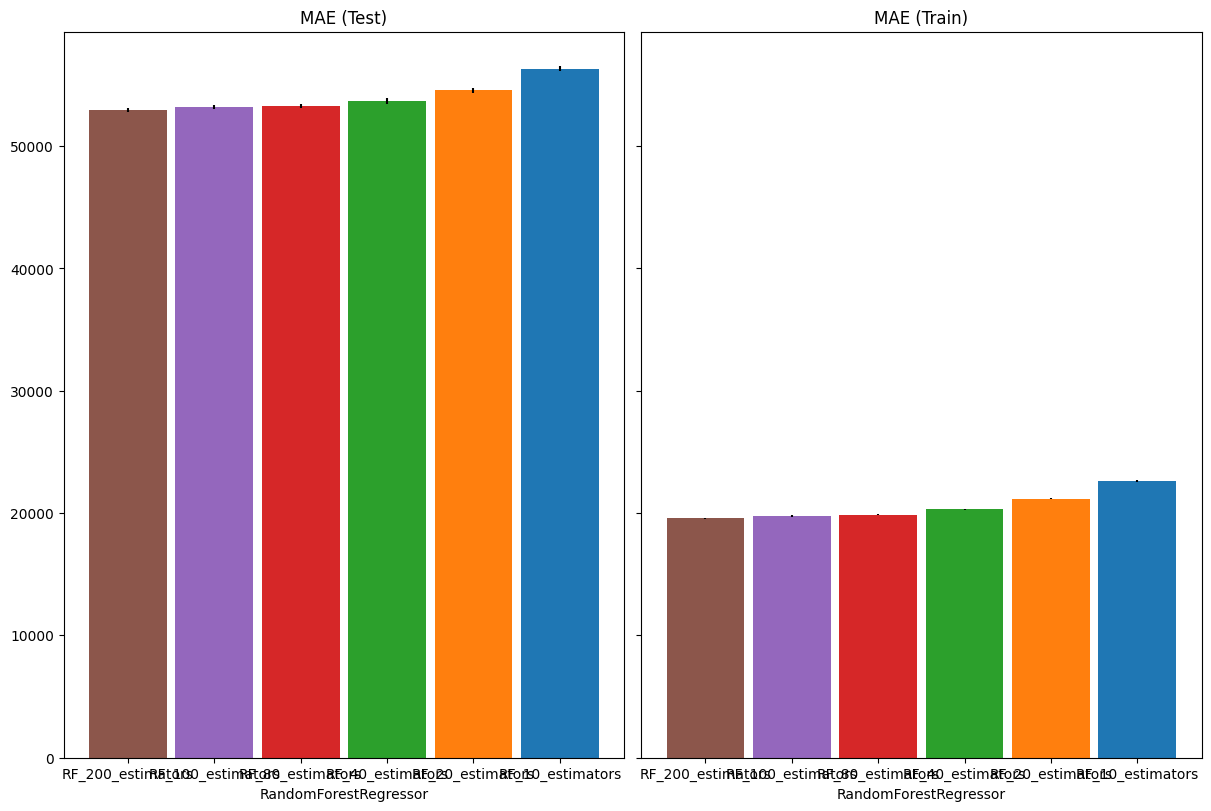

: 

In [ ]:
results = []
preprocessor = ColumnTransformer(
    [
        ("numerical", "passthrough", numerical_features),
        ("categorical", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_features),
    ]
)
imputer = KNNImputer(add_indicator = True)

for n in [10, 20, 40, 80, 100, 200] :
    pipe = make_pipeline(
        preprocessor, imputer, RandomForestRegressor(random_state = 0, n_estimators = n)
    )
    results = Utils.evaluate_model_and_store(X, y, f'RF_{n}_estimators', pipe, cv_shuffle_split, res = results)

Utils.visualize_results(results, 'RandomForestRegressor')
print(results)


# import joblib

# N_CORES = joblib.cpu_count(only_physical_cores=True)
# print(f"Number of physical cores: {N_CORES}")

# import sklearn
# sklearn.__version__

# cv = 5
# 10 [{'preprocessor': 'RF_mixed', 'mae_test_mean': 74066.02224320958, 'mae_test_std': 4519.617048746671, 'mae_train_mean': np.float64(30281.23555453936), 'mae_train_std': np.float64(532.2743772825276)}]
# 20 [{'preprocessor': 'RF_mixed', 'mae_test_mean': 72055.16786807033, 'mae_test_std': 4666.737317961463, 'mae_train_mean': np.float64(28767.310994755786), 'mae_train_std': np.float64(326.5353973465239)}]
# 40 [{'preprocessor': 'RF_mixed', 'mae_test_mean': 71220.4440704635, 'mae_test_std': 4806.345777440669, 'mae_train_mean': np.float64(28101.317570835236), 'mae_train_std': np.float64(433.7565218833997)}]
# 100 [{'preprocessor': 'RF_mixed', 'mae_test_mean': 70792.0981802605, 'mae_test_std': 5077.062412670087, 'mae_train_mean': np.float64(27227.863500398213), 'mae_train_std': np.float64(351.0547129906974)}]
# cv = ShuffleSplit
# imput strategy = 'most_frequent'
# 10 [{'preprocessor': 'RF_mixed', 'mae_test_mean': 57402.51838511275, 'mae_test_std': 262.05988736794205, 'mae_train_mean': np.float64(31275.45000069499), 'mae_train_std': np.float64(303.15856560996014)}]
# 20 [{'preprocessor': 'RF_mixed', 'mae_test_mean': 55770.280801110806, 'mae_test_std': 164.6662356240336, 'mae_train_mean': np.float64(29750.36747102884), 'mae_train_std': np.float64(221.1771759155025)}]
# 40 [{'preprocessor': 'RF_mixed', 'mae_test_mean': 54828.61959623456, 'mae_test_std': 84.12897356772608, 'mae_train_mean': np.float64(28841.36450312996), 'mae_train_std': np.float64(191.798492942728)}]
# 80 [{'preprocessor': 'RF_mixed', 'mae_test_mean': 54438.149266576256, 'mae_test_std': 168.52418844060693, 'mae_train_mean': np.float64(28423.870688516392), 'mae_train_std': np.float64(102.57082878119172)}]
# 100 [{'preprocessor': 'RF_mixed', 'mae_test_mean': 54316.075178356994, 'mae_test_std': 169.19241919138344, 'mae_train_mean': np.float64(28337.518931280378), 'mae_train_std': np.float64(93.89834809919317)}]

# imput strategy = 'constant'
# 10 [{'preprocessor': 'RF_mixed', 'mae_test_mean': 57274.11556649553, 'mae_test_std': 251.62271716502997, 'mae_train_mean': np.float64(30836.778439205587), 'mae_train_std': np.float64(187.45037644141988)}]
# 20 [{'preprocessor': 'RF_mixed', 'mae_test_mean': 55652.7992681767, 'mae_test_std': 151.71169059781306, 'mae_train_mean': np.float64(29217.389287709946), 'mae_train_std': np.float64(133.2039738491241)}]
# 40 [{'preprocessor': 'RF_mixed', 'mae_test_mean': 54620.68587364301, 'mae_test_std': 146.33745831780962, 'mae_train_mean': np.float64(28470.83546020522), 'mae_train_std': np.float64(67.663587782853)}]
# 80 [{'preprocessor': 'RF_mixed', 'mae_test_mean': 54155.33799103058, 'mae_test_std': 136.38611047332353, 'mae_train_mean': np.float64(27837.51809506091), 'mae_train_std': np.float64(149.76616095673933)}]
# 100 [{'preprocessor': 'RF_mixed', 'mae_test_mean': 54058.31109605188, 'mae_test_std': 167.40827777128754, 'mae_train_mean': np.float64(27766.41338526213), 'mae_train_std': np.float64(293.9656854248045)}]
# 200 [{'preprocessor': 'RF_mixed', 'mae_test_mean': 53779.831219597974, 'mae_test_std': 176.1449414364917, 'mae_train_mean': np.float64(27558.992090182255), 'mae_train_std': np.float64(80.56718971694998)}]
# KNNImputer
# [{'preprocessor': 'RF_10_estimators', 'mae_test_mean': np.float64(56339.37721217454), 'mae_test_std': np.float64(186.40486388601371), 
#                                       'mae_train_mean': np.float64(22639.756417188444), 'mae_train_std': np.float64(68.93386006374557)}, 
# {'preprocessor': 'RF_20_estimators', 'mae_test_mean': np.float64(54551.74647487652), 'mae_test_std': np.float64(189.99297242944493), 
#                                       'mae_train_mean': np.float64(21169.24023372001), 'mae_train_std': np.float64(67.81124906565006)}, 
# {'preprocessor': 'RF_40_estimators', 'mae_test_mean': np.float64(53659.40339537134), 'mae_test_std': np.float64(231.46840065668528), 
#                                       'mae_train_mean': np.float64(20288.42509415179), 'mae_train_std': np.float64(56.495563154585156)}, 
# {'preprocessor': 'RF_80_estimators', 'mae_test_mean': np.float64(53246.25008945294), 'mae_test_std': np.float64(166.8443321916972), 
#                                       'mae_train_mean': np.float64(19842.154526449944), 'mae_train_std': np.float64(38.53965308500937)}, 
# {'preprocessor': 'RF_100_estimators', 'mae_test_mean': np.float64(53180.82481836948), 'mae_test_std': np.float64(155.6215065928101), 
#                                       'mae_train_mean': np.float64(19752.233208111506), 'mae_train_std': np.float64(43.20415489681474)}, 
# {'preprocessor': 'RF_200_estimators', 'mae_test_mean': np.float64(52947.94953843464), 'mae_test_std': np.float64(132.87466380262927), 
#                                       'mae_train_mean': np.float64(19567.296476774012), 'mae_train_std': np.float64(44.45871392577869)}]